# Importing Libraries

In [18]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [19]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [20]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [21]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [22]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [23]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [24]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [25]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [28]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [29]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.iloc[:-1]

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [30]:
positions=positions.sort_index()

In [31]:
positions.index=pd.to_datetime(positions.index)

In [32]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [33]:
positions.to_excel('Positions.xlsx')

In [34]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [35]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=np.log(1+binance_data.pct_change())

LDUMAUSDT not retrieved
Total not retrieved


In [36]:
historical_ptf=pd.DataFrame()

In [37]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

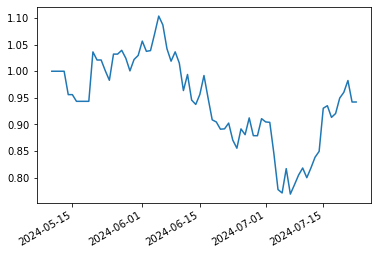

In [38]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [39]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [40]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [41]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'NEXOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT',
       'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT',
       'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

In [42]:
np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

(12, 21, 52)

## Optimal Portfolio

In [43]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[12]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[21]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[52]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.400000
OMUSDT,0.387352
PEPEUSDT,0.093290
BNBUSDT,0.063967
JASMYUSDT,0.055391


In [44]:
np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

(0, 4, 3)

In [45]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.40}])#,
                                                           #{'type': 'ineq', 'fun': lambda weights: weights[3]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[4]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.596798
BTCUSDT,0.400000
JASMYUSDT,0.003202


## Real Portfolio vs Optimal

In [46]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,703.814899,3.270752e-01,0.400000,-0.072925
JASMYUSDT,348.990361,1.621820e-01,0.003202,0.158980
OMUSDT,263.491379,1.224491e-01,0.596798,-0.474349
SOLUSDT,254.097755,1.180837e-01,0.000000,0.000000
ETHUSDT,240.554146,1.117897e-01,0.000000,0.000000
BBUSDT,134.708404,6.260137e-02,0.000000,0.000000
MKRUSDT,126.253735,5.867233e-02,0.000000,0.000000
BNBUSDT,59.045763,2.743961e-02,0.000000,0.000000
TRXUSDT,20.887996,9.707019e-03,0.000000,0.000000
PEPEUSDT,0.000003,1.375192e-09,0.000000,0.000000


In [47]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,703.814899,3.270752e-01,0.400000,-0.072925
JASMYUSDT,348.990361,1.621820e-01,0.055391,0.106791
OMUSDT,263.491379,1.224491e-01,0.387352,-0.264903
SOLUSDT,254.097755,1.180837e-01,0.000000,0.000000
ETHUSDT,240.554146,1.117897e-01,0.000000,0.000000
BBUSDT,134.708404,6.260137e-02,0.000000,0.000000
MKRUSDT,126.253735,5.867233e-02,0.000000,0.000000
BNBUSDT,59.045763,2.743961e-02,0.063967,-0.036527
TRXUSDT,20.887996,9.707019e-03,0.000000,0.000000
PEPEUSDT,0.000003,1.375192e-09,0.093290,-0.093290


## Risk Reward Analysis

<AxesSubplot:>

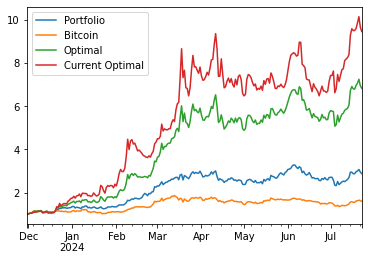

In [48]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [51]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

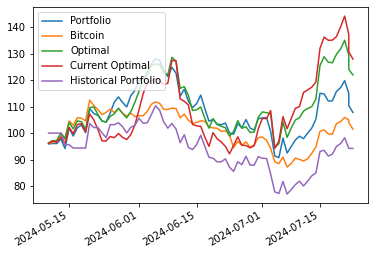

In [53]:
((1+current_perf).cumprod()*100).plot()

In [54]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.694604
dtype: float64

In [55]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.559544
dtype: float64

In [56]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.515492
Bitcoin            0.437933
Optimal            0.696017
Current Optimal    0.885625
dtype: float64

In [57]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.008559,0.013848,0.020583,0.002159,0.018424
BTCUSDT,0.025246,0.061017,0.172205,0.063343,0.108862
JASMYUSDT,0.012252,0.016370,0.037705,0.008415,0.029290
OMUSDT,0.915355,0.864957,0.674916,0.573953,0.100963
PEPEUSDT,0.038587,0.043809,0.094592,0.033779,0.060813


In [58]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.075745,0.302463,0.191157,0.048371,0.142786
JASMYUSDT,0.335202,0.178975,0.265684,0.102822,0.162862
OMUSDT,0.579767,0.169794,0.137410,0.040369,0.097041
SOLUSDT,0.098063,0.117624,0.124554,0.022067,0.102487
ETHUSDT,0.123813,0.111496,0.080082,0.009790,0.070292
BBUSDT,-0.195108,0.032371,0.126053,0.033373,0.092680
MKRUSDT,-0.010615,0.052352,0.053917,0.005598,0.048318
BNBUSDT,-0.011525,0.025503,0.019590,0.000621,0.018969
TRXUSDT,0.004658,0.009421,0.001554,0.000017,0.001537


## Value At Risk

### Historical

In [59]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05694571939780063, -0.0839607359179449)

In [60]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.046978457048465865, -0.06744327858800088)

### Parametric

In [61]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0721185106226462, -0.09243599095436894)

In [62]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.057977695516200696, -0.07431137570674975)

### Multivariate

In [63]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06244700322296674, -0.08064517413510637)

In [64]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05453802339147494, -0.06931737310105487)

### Copulas

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06338726701886488, -0.08132404040247995)

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.053968110406135486, -0.06960392057227904)

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06343185129984756, -0.08081027173818438)

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05591761880950607, -0.07197082578805798)

### Monte Carlo

In [69]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07552797461755043, -0.09390191925213506)

In [70]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05883183926186174, -0.07387339616016521)

### VaR Violation

In [71]:
var_data=rolling_var(returns_to_use,opt_weights,window=25,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-09,-0.053887,-0.096939,-0.079724,-0.006759
2024-01-10,-0.053887,-0.096911,-0.083760,0.015486
2024-01-11,-0.053887,-0.095853,-0.076099,0.001025
2024-01-12,-0.059041,-0.102610,-0.084782,-0.060615
2024-01-13,-0.059041,-0.102477,-0.086535,0.009525
...,...,...,...,...
2024-07-19,-0.102937,-0.101515,-0.091694,0.025581
2024-07-20,-0.102937,-0.100525,-0.093309,0.015544
2024-07-21,-0.102937,-0.099016,-0.088867,0.025013
2024-07-22,-0.102937,-0.102140,-0.091448,-0.041778


In [72]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.036030,-0.091504,-0.082448,-0.018411
2024-05-29,-0.029214,-0.088048,-0.078565,-0.015053
2024-05-30,-0.029214,-0.077743,-0.069269,0.038785
2024-05-31,-0.027219,-0.073998,-0.062966,0.016871
2024-06-01,-0.027219,-0.074327,-0.064687,0.034421
2024-06-02,-0.027219,-0.074513,-0.062694,0.002653
2024-06-03,-0.019607,-0.070087,-0.055746,0.013109
2024-06-04,-0.019607,-0.052050,-0.041154,0.033960
2024-06-05,-0.019607,-0.049225,-0.037247,0.015608
2024-06-06,-0.019607,-0.048937,-0.036234,-0.004467


<AxesSubplot:>

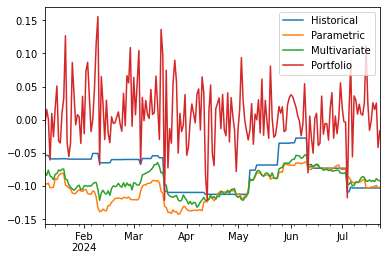

In [73]:
var_data.plot()

<AxesSubplot:>

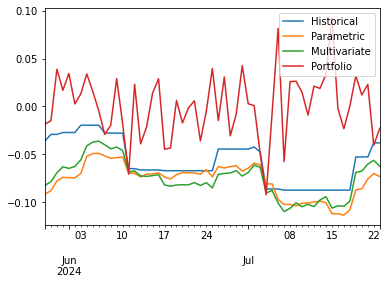

In [74]:
current_var_data.plot()

In [75]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.030457,0.010152,0.020305
Kupiec Stat,1.83012,9.647461,4.671569
P-value,0.176113,0.001896,0.030666


In [76]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.087719,0.035088,0.035088
Kupiec Stat,1.407707,0.296586,0.296586
P-value,0.235437,0.586031,0.586031


## Principal Component Analysis

In [77]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76431631, 0.07502037, 0.06253603, 0.05424733, 0.04387997])

In [78]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.61633783, 0.16661185, 0.09540307, 0.07807183, 0.04357542])

In [79]:
"""faire contrib a la var de chaques modeles"""

'faire contrib a la var de chaques modeles'

In [80]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

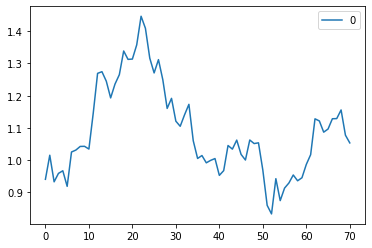

In [81]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

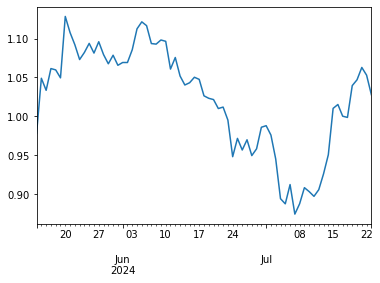

In [82]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()